# Linear Regression

## From Scratch

This section walks through building a complete linear regression implementation from scratch, covering the model, loss function, minibatch SGD optimizer, and training loop, then applying it to synthetic data. Although deep learning frameworks can automate these steps, implementing them manually builds a deeper understanding that is essential for customizing models in the future.

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### Model

Here, the model’s weights are initialized by sampling from a normal distribution with mean 0
and standard deviation 0.01.


In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [3]:
!d2l.Module

zsh:1: command not found: d2l.Module


Next, we define the model, specifying how the inputs and parameters are mathematically combined to produce the output.

In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

### Loss Function

Here we use the squared loss function.

In [5]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

### Optimization Algorithm

We define a SGD class and make an instance of it. 

In [6]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [7]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

### Training

With the parameters, loss function, model, and optimizer defined, we can now implement the main training loop to fit the model to the data.

In [8]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        # print('batch size = ', len(batch))
        #1. compute loss
        loss = self.model.training_step(self.prepare_batch(batch))
        #2. make sure gradients are zeroed
        self.optim.zero_grad()
        #3. compute gradients
        loss.backward()
        #4. update parameters
        with torch.no_grad():
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    # validation phase if validation set is provided
    if self.val_dataloader is None:
        return
    #1. set model to eval mode
    self.model.eval()
    for batch in self.val_dataloader:
        #2. no gradient tracking in validation phase
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Note that in general, both the number of epochs and the learning rate are `hyperparameters`. In general, setting hyperparameters is tricky and we will usually want to use a three-way split, one set for training, a second for hyperparameter selection, and the third reserved for the final evaluation. 

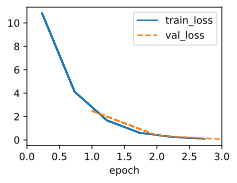

In [18]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [19]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0906, -0.2289])
error in estimating b: tensor([0.2348])


## Exercises

### 1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

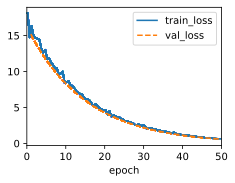

In [44]:
model = LinearRegressionScratch(2, lr=0.001)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=50)
trainer.fit(model, data)

# Smaller learning rate leads to slower convergence, safe but inefficient
# Larger learning rate leads to faster convergence, but may be unstable
# Few epochs may not be enough for convergence
# Large epochs ensures that the model converges, but eventually won't improve anymore

### 2. If the number of examples cannot be divided by the batch size, what happens to data_iter at the end of an epoch?

It will return the last smaller batch, just the number of samples in the last batch would be smaller. So if there are 10 samples total and the batch size is 4, then batches will be of size [4, 4, 2]

## Concise Implementation

In this section, we demonstrate a concise implementation of the linear regression model using high-level deep learning APIs. These abstractions streamline the code while preserving the same structure and logic as the from-scratch version.

In [34]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### Model

Now we use a framework’s predefined layers, enabling us to focus on selecting and arranging the model’s layers without dealing with their low-level implementation details.

In [35]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [36]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

### Loss Function

Again, we use pre-defined loss function.

In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

### Optimization Algorithm

Minibatch SGD is a common optimization method for training neural networks, and PyTorch’s optim module provides built-in support for it along with several variations of the algorithm.

In [35]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

### Training

Now that we have all the basic pieces in place, the training loop itself is the same as the one we implemented from scratch.

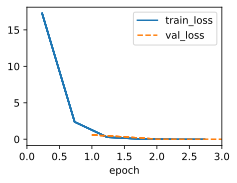

In [45]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [46]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0045, -0.0041])
error in estimating b: tensor([0.0114])


## Exercises

### Ex. 3:

#### Consider the following definitions and then answer the question:
#### - __Aggregate loss__ (sum): the minibatch loss is defined by the sum of the individual sample losses.
#### - __Average loss__ (mean): the minibatch loss is defined as the mean of the sample losses (so the sum divided by the minibatch size).

#### How would you need to change the learning rate if you replace the aggregate loss with an average loss?

If you replace the aggregate loss with an average loss, the gradient becomes $\frac{1}{Batch Size}$ times smaller. So you'd need to increase the learning rate by a factor of the batch size to ensure the updates are the same size. 

### Ex. 4:

#### How do you access the gradient of the weights of the model?

For example, say the model has weights **w**. You have to do a backward pass to compute the gradients, then you can access them.

```python
# Forward pass
y_hat = model(X) # Predicted values
loss = loss_fn(y_hat, y) # Computing loss

# Backward pass
loss.backward() # Computes gradients

print(model.w.grad) # Weights
```

### Ex. 5:

#### Replace the squared loss with Huber’s robust loss function and run the training again. You can uncomment the line below to read more about the nn.HuberLoss available pytorch.

In [48]:
nn.HuberLoss?

Init signature: nn.HuberLoss(reduction: str = 'mean', delta: float = 1.0) -> None
Docstring:     
Creates a criterion that uses a squared term if the absolute
element-wise error falls below delta and a delta-scaled L1 term otherwise.
This loss combines advantages of both :class:`L1Loss` and :class:`MSELoss`; the
delta-scaled L1 region makes the loss less sensitive to outliers than :class:`MSELoss`,
while the L2 region provides smoothness over :class:`L1Loss` near 0. See
`Huber loss <https://en.wikipedia.org/wiki/Huber_loss>`_ for more information.

For a batch of size :math:`N`, the unreduced loss can be described as:

.. math::
    \ell(x, y) = L = \{l_1, ..., l_N\}^T

with

.. math::
    l_n = \begin{cases}
    0.5 (x_n - y_n)^2, & \text{if } |x_n - y_n| < delta \\
    delta * (|x_n - y_n| - 0.5 * delta), & \text{otherwise }
    \end{cases}

If `reduction` is not `none`, then:

.. math::
    \ell(x, y) =
    \begin{cases}
        \operatorname{mean}(L), &  \text{if reduction} = \text

In [49]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.HuberLoss()
    return fn(y_hat, y)

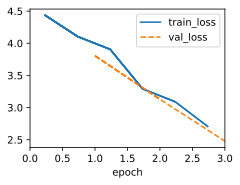

In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

# Cuts off the drop off at the start of the previous training